# MRI Brain Tumour Classifier, based on Google's Xception Model
References:
- https://keras.io/api/applications/xception/
- https://towardsdatascience.com/review-xception-with-depthwise-separable-convolution-better-than-inception-v3-image-dc967dd42568
- https://www.kaggle.com/code/alexandrelemercier/99-8-accuracy-on-brain-tumor-classification

In [1]:
# Import required functions and libraries
from utils import *
from sklearn.model_selection import StratifiedKFold, KFold
import json

# Dataset Preparations

Found 480 files belonging to 4 classes.
Using 384 files for training.
Using 96 files for validation.


Python(15257) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2024-07-09 12:19:31.921660: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-07-09 12:19:31.921688: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-07-09 12:19:31.921698: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-07-09 12:19:31.921715: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-09 12:19:31.921729: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)



Training Dataset Preview


2024-07-09 12:19:32.558763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


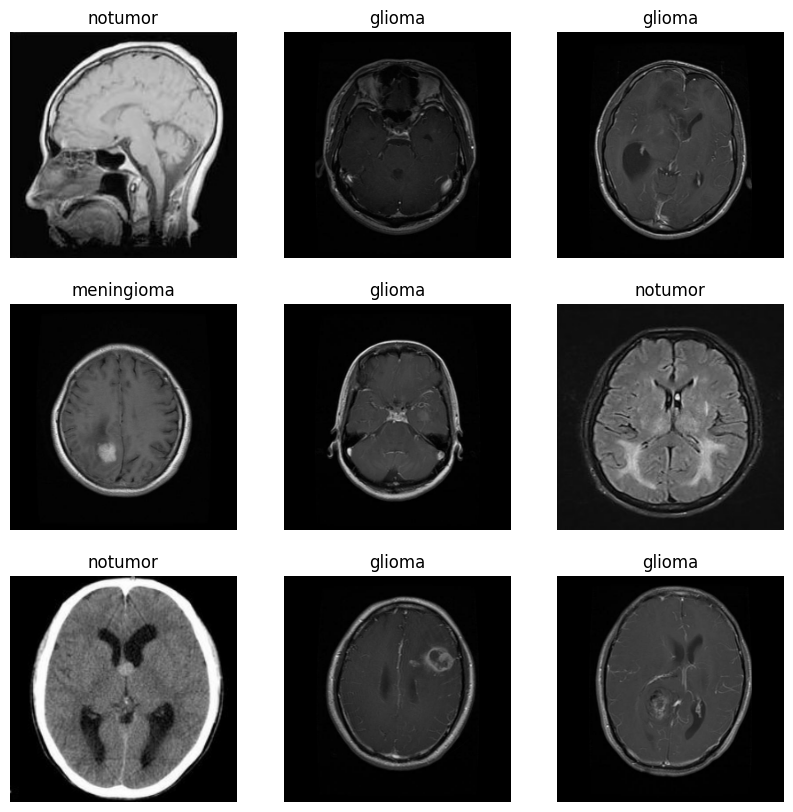

Validation Dataset Preview


2024-07-09 12:19:32.985518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


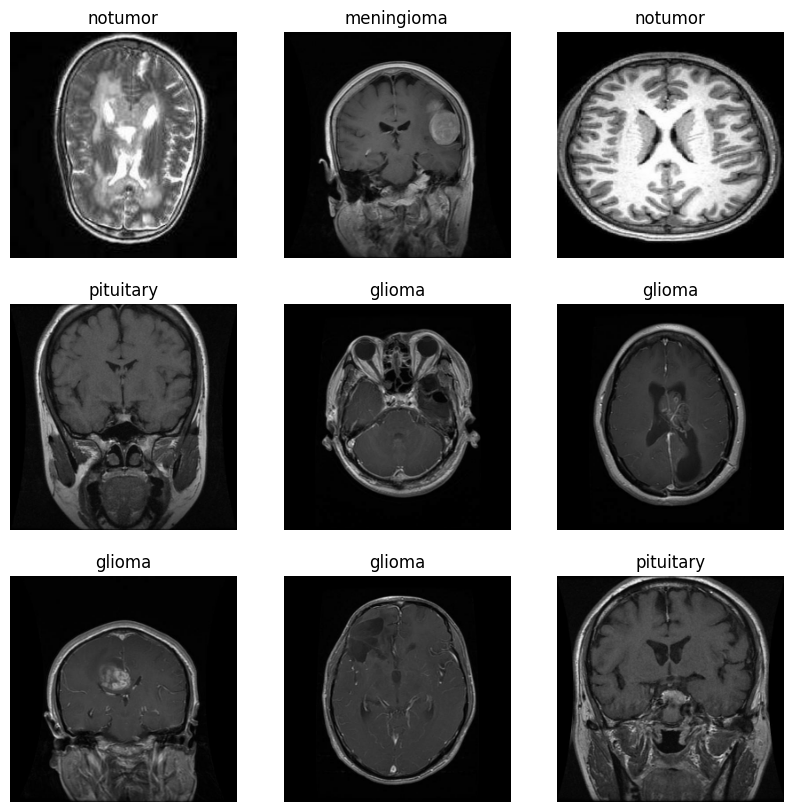

In [2]:
# Parameters
img_batch_size = 32
img_height = 256
img_width = 256
img_size = (img_height, img_width)
img_shape = img_size + (3,)

# Get training and validation datasets
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_FOLDER,
  validation_split=SPLIT_SIZE,
  subset="both",
  shuffle=True,
  seed=RANDOM_STATE,
  image_size=img_size,
  batch_size=img_batch_size)

# Get class names
class_names = train_ds.class_names
# class_names = val_ds.class_names

# Enable buffered prefetching to overlap data preprocessing and model execution during training, to speed up access to dataset
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Preview datasets
print("\nTraining Dataset Preview")
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

print("Validation Dataset Preview")
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

## Build the base model
Create a base model, by attaching a new classification head on top of the EfficientNetB0 model for transfer learning.

In [3]:
base_model = tf.keras.applications.Xception(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate= 0.3),
    tf.keras.layers.Dense(128, activation= 'relu'),
    tf.keras.layers.Dropout(rate= 0.25),
    tf.keras.layers.Dense(len(class_names), activation= 'softmax')
])

model.compile(tf.keras.optimizers.Adamax(learning_rate= 0.001), loss= 'sparse_categorical_crossentropy', metrics= ['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

## Model Training

In [4]:
history = model.fit(train_ds, validation_data=val_ds, epochs=50, batch_size=64)

Epoch 1/50


2024-07-09 12:19:47.135500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


12/12 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.4409 - loss: 1.9144 - val_accuracy: 0.3958 - val_loss: 1.6018
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.7688 - loss: 0.7120 - val_accuracy: 0.4792 - val_loss: 1.3563
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9280 - loss: 0.2646 - val_accuracy: 0.6562 - val_loss: 0.7795
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9560 - loss: 0.1226 - val_accuracy: 0.6979 - val_loss: 0.9319
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9765 - loss: 0.0785 - val_accuracy: 0.8125 - val_loss: 0.6291
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9793 - loss: 0.0617 - val_accuracy: 0.8021 - val_loss: 0.6953
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 1.0000 - loss: 0.0110 - val_accuracy: 0.8229 - val_loss: 0.6918
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9991 - loss: 0.0056 - val_accuracy: 0.8958 - val_loss: 0.4817
Epo

## Visualise Training

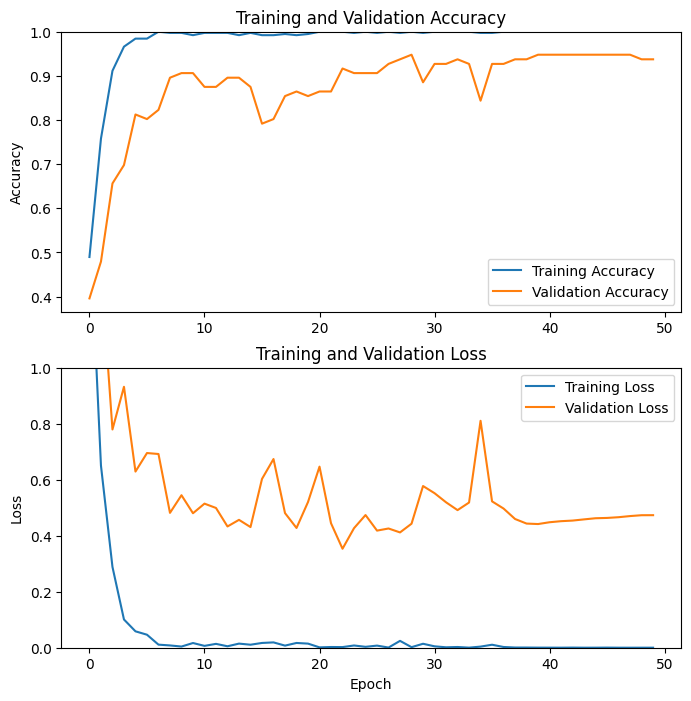

Training Results:
~Accuracy~
Max (best) accuracy: 1.0 at epoch 7
Min (worst) accuracy: 0.4895833432674408 at epoch 1
Median accuracy: 0.9986979067325592
Mean accuracy: 0.9802604120969772

~Loss~
Min (best) loss: 5.429058728623204e-05 at epoch 48
Max (worst) loss: 1.5363259315490723 at epoch 1
Median loss: 0.004624232416972518
Mean loss: 0.05888019232625084

~Final Training Performance~
Accuracy: 1.0, Loss: 5.287876319925999e-06

Validation Results:
~Accuracy~
Max (best) accuracy: 0.9479166865348816 at epoch 29
Min (worst) accuracy: 0.3958333432674408 at epoch 1
Median accuracy: 0.90625
Mean accuracy: 0.8743750011920929

~Loss~
Min (best) loss: 0.35348883271217346 at epoch 23
Max (worst) loss: 1.6017848253250122 at epoch 1
Median loss: 0.47708187997341156
Mean loss: 0.5546350955963135

~Final Validation Performance~
Accuracy: 0.9375, Loss: 0.47336506843566895


In [5]:
# Visualise model performance throughout epochs
# Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
# Loss
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

# Get epoch of optimal parameters
print("Training Results:")
print("~Accuracy~")
print("Max (best) accuracy:", max(history.history['accuracy']), "at epoch", history.history['accuracy'].index(max(history.history['accuracy'])) + 1)
print("Min (worst) accuracy:", min(history.history['accuracy']), "at epoch", history.history['accuracy'].index(min(history.history['accuracy'])) + 1)
print("Median accuracy:", np.median(history.history['accuracy']))
print("Mean accuracy:", np.mean(history.history['accuracy']))

print("\n~Loss~")
print("Min (best) loss:", min(history.history['loss']), "at epoch", history.history['loss'].index(min(history.history['loss'])) + 1)
print("Max (worst) loss:", max(history.history['loss']), "at epoch", history.history['loss'].index(max(history.history['loss'])) + 1)
print("Median loss:", np.median(history.history['loss']))
print("Mean loss:", np.mean(history.history['loss']))

print("\n~Final Training Performance~")
print("Accuracy: {1}, Loss: {0}".format(*model.evaluate(train_ds, verbose=0)))

print("\nValidation Results:")
print("~Accuracy~")
print("Max (best) accuracy:", max(history.history['val_accuracy']), "at epoch", history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1)
print("Min (worst) accuracy:", min(history.history['val_accuracy']), "at epoch", history.history['val_accuracy'].index(min(history.history['val_accuracy'])) + 1)
print("Median accuracy:", np.median(history.history['val_accuracy']))
print("Mean accuracy:", np.mean(history.history['val_accuracy']))

print("\n~Loss~")
print("Min (best) loss:", min(history.history['val_loss']), "at epoch", history.history['val_loss'].index(min(history.history['val_loss'])) + 1)
print("Max (worst) loss:", max(history.history['val_loss']), "at epoch", history.history['val_loss'].index(max(history.history['val_loss'])) + 1)
print("Median loss:", np.median(history.history['val_loss']))
print("Mean loss:", np.mean(history.history['val_loss']))

print("\n~Final Validation Performance~")
print("Accuracy: {1}, Loss: {0}".format(*model.evaluate(val_ds, verbose=0)))

## Model Performance

In [7]:
print("~Training Metrics~")
get_model_metrics(train_ds, model)

print("\n~Validation Metrics~")
get_model_metrics(val_ds, model)

~Training Metrics~


2024-07-09 12:39:35.241696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Matthews Correlation Coefficient (MCC): 1.0
Cohen's Kappa: 1.0
Hamming Loss: 0.0

Confusion Matrix:
 [[97  0  0  0]
 [ 0 93  0  0]
 [ 0  0 97  0]
 [ 0  0  0 97]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        97
           1       1.00      1.00      1.00        93
           2       1.00      1.00      1.00        97
           3       1.00      1.00      1.00        97

    accuracy                           1.00       384
   macro avg       1.00      1.00      1.00       384
weighted avg       1.00      1.00      1.00       384



~Validation Metrics~
Accuracy: 0.9375
Precision: 0.9424780131301871
Recall: 0.9380032206119162
F1 Score: 0.937537630921266
Matthews Correlation Coefficient (MCC): 0.9183000140855853
Cohen's Kappa: 0.9165701042873696
Hamming Loss: 0.0625

Confusion Matrix:
 [[22  0  0  1]
 [ 0 25  0  2]
 [ 1  1 20  1]
 [ 0  0  0 23]]

Cl

2024-07-09 12:39:36.220931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# K-Fold Cross-Validation to validate model performance

In [ ]:
""" K-Fold Cross-Validation """
# Load dataset without validation split
dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_FOLDER,
    shuffle=True,
    seed=RANDOM_STATE,
    image_size=img_size,
    batch_size=img_batch_size
)

# Convert dataset to numpy arrays for k-fold splitting
images = []
labels = []
for image, label in dataset:
    images.append(image.numpy())
    labels.append(label.numpy())
images = np.concatenate(images)
labels = np.concatenate(labels)

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Initialise lists to store results
list_kf_results = []
list_skf_results = []

print("K-Fold Cross-Validation")
fold_no = 0
for train_index, val_index in kf.split(images):
    # Split data
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]
    
    # Create TensorFlow datasets
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

    # Prefetch datasets
    train_ds = train_ds.batch(img_batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(img_batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    # Train the model
    history = model.fit(train_ds, validation_data=val_ds, epochs=50, batch_size=64, verbose=0)
    
    # Evaluate the model
    train_loss, train_accuracy = model.evaluate(train_ds, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_ds, verbose=0)
    
    # Save results
    list_kf_results.append({"train_loss": train_loss, "train_accuracy": train_accuracy, "val_loss": val_loss, "val_accuracy": val_accuracy, "history": history})
    
    print("Fold Index", fold_no)
    print("~Training Dataset~\nAccuracy: {}, Loss: {}".format(train_accuracy, train_loss))
    print("~Validation Dataset~\nAccuracy: {}, Loss: {}".format(val_accuracy, val_loss), end="\n\n")
    
    # Increment fold number
    fold_no += 1
    
print("\nStratified K-Fold Cross-Validation")
fold_no = 0
for train_index, val_index in skf.split(images, labels):
    # Split data
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]
    
    # Create TensorFlow datasets
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

    # Prefetch datasets
    train_ds = train_ds.batch(img_batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(img_batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    # Train the model
    history = model.fit(train_ds, validation_data=val_ds, epochs=50, batch_size=64, verbose=0)
    
    # Evaluate the model
    train_loss, train_accuracy = model.evaluate(train_ds, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_ds, verbose=0)
    
    # Save results
    list_skf_results.append({"train_loss": train_loss, "train_accuracy": train_accuracy, "val_loss": val_loss, "val_accuracy": val_accuracy, "history": history})
    
    print("Fold Index", fold_no)
    print("~Training Dataset~\nAccuracy: {}, Loss: {}".format(train_accuracy, train_loss))
    print("~Validation Dataset~\nAccuracy: {}, Loss: {}".format(val_accuracy, val_loss), end="\n\n")
    
    # Increment fold number
    fold_no += 1

Found 480 files belonging to 4 classes.


2024-07-08 16:24:27.187762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


K-Fold Cross-Validation
Fold Index 0
~Training Dataset~
Accuracy: 1.0, Loss: 0.00040429385262541473
~Validation Dataset~
Accuracy: 0.9056865348814166, Loss: 0.4635545313358307

Fold Index 1
~Training Dataset~
Accuracy: 1.0, Loss: 0.00012155903823440894
~Validation Dataset~
Accuracy: 0.9846511958339384, Loss: 0.4661283791065216

Fold Index 2
~Training Dataset~
Accuracy: 1.0, Loss: 5.429058728623204e-05
~Validation Dataset~
Accuracy: 1.0, Loss: 0.47017431259155273

Fold Index 3
~Training Dataset~
Accuracy: 1.0, Loss: 0.00011683066986734048
~Validation Dataset~
Accuracy: 1.0, Loss: 0.47322705388069153

Fold Index 4
~Training Dataset~
Accuracy: 1.0, Loss: 0.0001265816536033526
~Validation Dataset~
Accuracy: 1.0, Loss: 0.47336506843566895


Stratified K-Fold Cross-Validation
Fold Index 0
~Training Dataset~
Accuracy: 1.0, Loss: 0.00024370010942220688
~Validation Dataset~
Accuracy: 1.0, Loss: 0.44814300537109375

Fold Index 1
~Training Dataset~
Accuracy: 1.0, Loss: 0.00015346442523878068
~Val

In [ ]:
print("K-Fold Cross-Validation Results")
# Extract values
train_accuracies = [result['train_accuracy'] for result in list_kf_results]
train_losses = [result['train_loss'] for result in list_kf_results]
val_accuracies = [result['val_accuracy'] for result in list_kf_results]
val_losses = [result['val_loss'] for result in list_kf_results]

# Print results
print(json.dumps({
    'Training Accuracy': calculate_statistics(train_accuracies),
    'Training Loss': calculate_statistics(train_losses),
    'Validation Accuracy': calculate_statistics(val_accuracies),
    'Validation Loss': calculate_statistics(val_losses)
}, indent=4))

print("\nStratified K-Fold Cross-Validation Results")
# Extract values
train_accuracies = [result['train_accuracy'] for result in list_skf_results]
train_losses = [result['train_loss'] for result in list_skf_results]
val_accuracies = [result['val_accuracy'] for result in list_skf_results]
val_losses = [result['val_loss'] for result in list_skf_results]

# Print results
print(json.dumps({
    'Training Accuracy': calculate_statistics(train_accuracies),
    'Training Loss': calculate_statistics(train_losses),
    'Validation Accuracy': calculate_statistics(val_accuracies),
    'Validation Loss': calculate_statistics(val_losses)
}, indent=4))

K-Fold Cross-Validation Results
{
    "Training Accuracy": {
        "max": 1.0,
        "min": 1.0,
        "median": 1.0,
        "mean": 1.0
    },
    "Training Loss": {
        "max": 0.01602288894355297,
        "min": 0.00020227320783305913,
        "median": 0.0025432498659938574,
        "mean": 0.005499125810456462
    },
    "Validation Accuracy": {
        "max": 1.0,
        "min": 0.9056865348814166,
        "median": 1.0,
        "mean": 0.9780675461430711
    },
    "Validation Loss": {
        "max": 0.18682862649515272,
        "min": 0.0034049965224369834,
        "median": 0.009219604262811959,
        "mean": 0.052414565906992526
    }
}

Stratified K-Fold Cross-Validation Results
{
    "Training Accuracy": {
        "max": 1.0,
        "min": 1.0,
        "median": 1.0,
        "mean": 1.0
    },
    "Training Loss": {
        "max": 8.546223755249776e-05,
        "min": 2.018004191584443e-06,
        "median": 2.1537606982326696e-05,
        "mean": 3.11341402011

The model based on Xception returns optimal performance consistently throughout, given its relatively simple classification head, components and hyperparameters. Xception is a large model, and requires a large amount of computational resources and time for further fine-tuning. We will use this initial model as the final model for Transfer Learning with Xception, without further fine-tuning of hyper-parameters to prevent overfitting.

Notably, the Xception model has a median training and validation accuracy of `100%` for both K-Fold and Stratified K-Fold Cross-Validation. It also has a training accuracy of `100%` and validation accuracy of `93.75%` for the dataset.

In [8]:
# Export model
model.save(MODEL_FILE)

# Load the trained model
# model = keras.models.load_model(MODEL_FILE)